In [19]:
# imports
import numpy as np
import cv2
import glob
import os
import pickle
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import *
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# constants
data_path = './data/'
const = {
    'vehicles_data' : os.path.join(data_path, 'vehicles/'),
    'non_vehicles_data' : os.path.join(data_path, 'non-vehicles/'),
    'test_images' : './test_images',
    'models' : './models/',
    'project_video' : './project_video.mp4',
    'output_videos' : './output_videos/',
    'test_video' : './test_video.mp4'
}

### Data Load and Exploration

In [3]:
# Helper function that loads the training dataset
def load_images(path):
    imgs_paths = []
    imgs = []
    
    for d in os.listdir(path):
        dir_path = os.path.join(path, d)    
        imgs_paths.extend(glob.glob(os.path.join(dir_path, '*.png')))
    
    
    for path in imgs_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    
    return np.asarray(imgs)
    
vehicle_imgs = load_images(const['vehicles_data'])   
non_vehicle_imgs = load_images(const['non_vehicles_data'])   

data type: vechicles
number of data points: 8792
shape of each data point: (64, 64, 3)
10 randomly seleted samples:


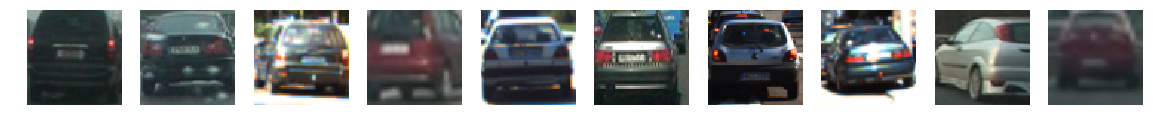

data type: non-vechicles
number of data points: 8968
shape of each data point: (64, 64, 3)
10 randomly seleted samples:


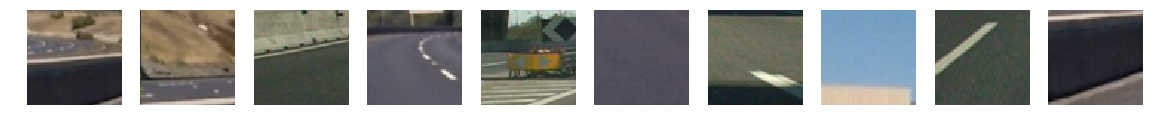

In [4]:
# Helper function that does some basic exploration and sanity check
def exploratory_analysis(data, dataset_name=None, seed=13, sample_size=10):
    np.random.seed(seed)
    print('data type:', dataset_name)
    print('number of data points:', data.shape[0])
    print('shape of each data point:', data.shape[1:])
    #print('data stored in:', type(data))
    print('{} randomly seleted samples:'.format(sample_size))
    sample_idx = np.random.randint(0, high=data.shape[0]-1, size=sample_size)
    f, ax = plt.subplots(1, sample_size, figsize=(20, 10*sample_size))
    for i, idx in enumerate(sample_idx):
        img = data[idx]
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()
    
exploratory_analysis(vehicle_imgs, dataset_name='vechicles')
exploratory_analysis(non_vehicle_imgs, dataset_name='non-vechicles')

### Feature Extraction

In [5]:
# Helper method to extract hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transform_sqrt, visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Helper method to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Helper method to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Helper method to extract features an image
def extract_features(imgs, params): 
    color_space=params['color_space']
    spatial_size=params['spatial_size']
    hist_bins=params['hist_bins'] 
    orient=params['orient']
    pix_per_cell=params['pix_per_cell']
    cell_per_block=params['cell_per_block']
    hog_channel=params['hog_channel']
    spatial_feat=params['spatial_feat']
    hist_feat=params['hist_feat']
    hog_feat=params['hog_feat']
    
    
    features = []
    for image in imgs:
        file_features = []
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
                
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, 
                                                feature_vec=True)
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))
    return features

/udacity/jovan/CarND-Vehicle-Detection/.car-nd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


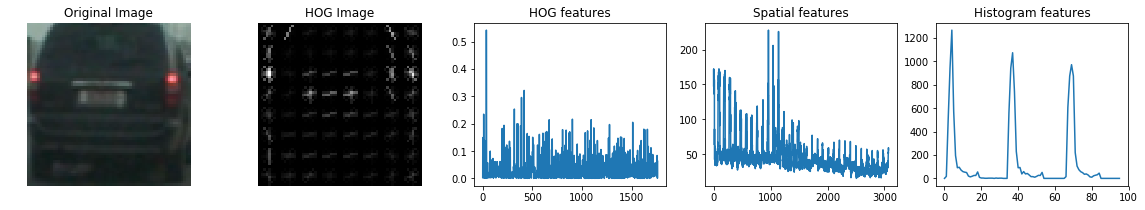

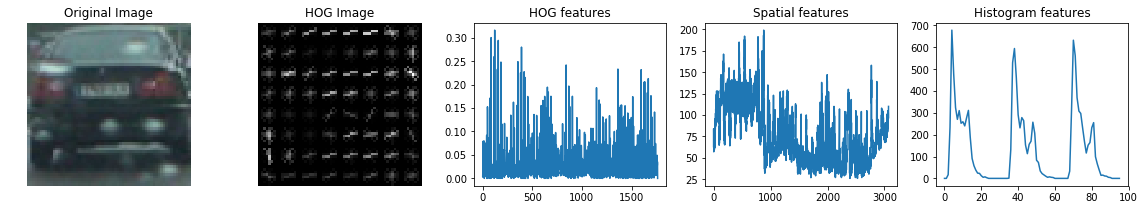

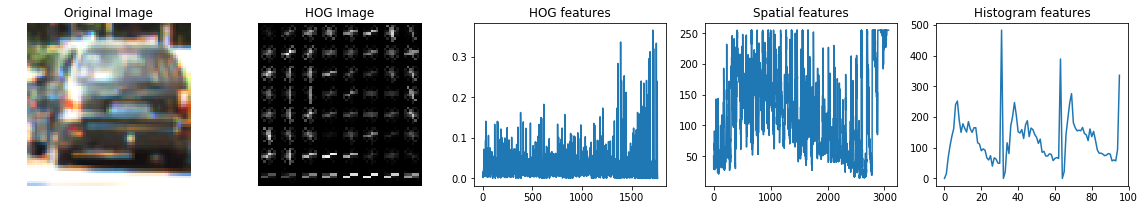

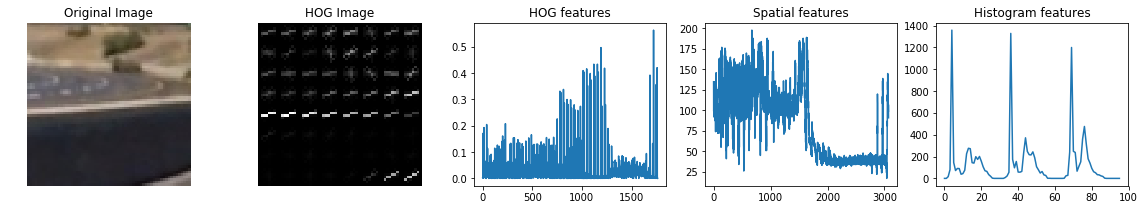

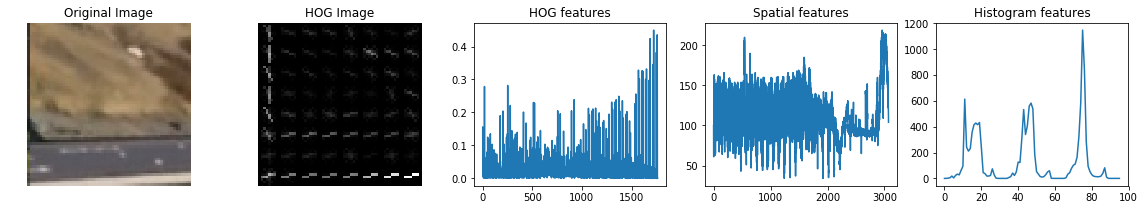

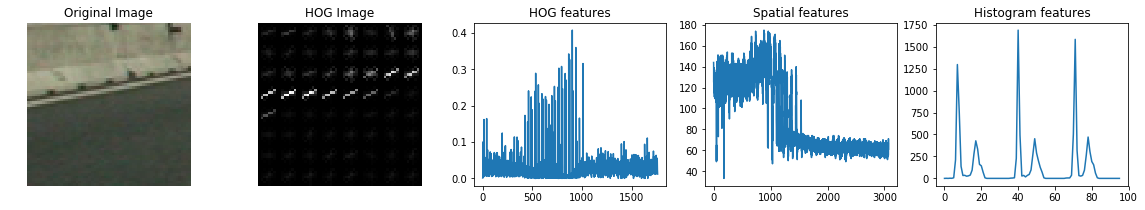

In [6]:
# Helper function that visulizes the features extracted
def visualize_features(data, sample_size=3, seed=13):
    np.random.seed(seed)
    random_idxs = np.random.randint(0, high=data.shape[0]-1, size=sample_size)
    for random_idx in random_idxs:
        img = data[random_idx]
        hog_features, hog_img = get_hog_features(img[:,:, 0], 9, 8, 2, vis=True, feature_vec=True)
        spatial_features = bin_spatial(img)
        hist_features = color_hist(img)

        fig, ax = plt.subplots(1, 5, figsize=(20, 3))
        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(hog_img, cmap='gray')
        ax[1].set_title('HOG Image')
        ax[1].axis('off')

        ax[2].plot(hog_features)
        ax[2].set_title('HOG features')

        ax[3].plot(spatial_features)
        ax[3].set_title('Spatial features')

        ax[4].plot(hist_features)
        ax[4].set_title('Histogram features')
        plt.show()
    
visualize_features(vehicle_imgs)
visualize_features(non_vehicle_imgs)

In [7]:
# A list of HOG hyperparams
feature_extraction_hyperparams = {
    'color_space': 'LUV',       # [RGB, HSV, LUV, HLS, YUV, YCrCb]
    'orient': 9,                # HOG orientations
    'pix_per_cell': 16,         # HOG pixels per cell
    'cell_per_block': 2,        # HOG cells per block
    'hog_channel': 'ALL',       # [0, 1, 2, "ALL"]
    'spatial_size': (16, 16),   # Spatial binning dimensions
    'hist_bins': 16,            # Number of histogram bins
    'spatial_feat': True,       # Spatial features on or off
    'hist_feat': True,          # Histogram features on or off
    'hog_feat': True,           # HOG features on or off
}

In [10]:
# Function that creates the features and preps the data for traning.
# Feature scaling and normalization is also done here and the scaler is returned for downstream functions.
def data_prep(seed=13):
    vehicle_features = extract_features(vehicle_imgs, feature_extraction_hyperparams)
    non_vehicle_features = extract_features(non_vehicle_imgs, feature_extraction_hyperparams)

    x = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
    scaler = StandardScaler().fit(x)
    x_scaled = scaler.transform(x)
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

    x_train, x_val, y_train, y_val = train_test_split(x_scaled, y, test_size=0.2, random_state=seed)
    
    return x_train, x_val, y_train, y_val, scaler

x_train, x_val, y_train, y_val, scaler = data_prep()

/udacity/jovan/CarND-Vehicle-Detection/.car-nd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Model Training

In [11]:
model_hyperparams = {
    'model_type': 'SVM',        # Type of model selected
    'C': 1.0,                   # SVM penalty parameter
    'kernel': 'linear',         # SVM kernel type
    'gamma': 'auto',            # SVM gamma parameter
    'min_samples_split': 5      # min_samples_split for boosting clf
}

In [ ]:
# Main function that trains and evalues the model 
def train_model(feature_extraction_hyperparams,
                x_train, x_val, y_train, y_val,
                model_type, save_model=True):
    
    model_stats = {}
    if model_type == 'LinearSVC':
        clf = LinearSVC() 
    elif model_type == 'RandomForestClassifier':
        clf = RandomForestClassifier()
    elif model_type == 'GaussianNB':
        clf = GaussianNB()
    else:
        assert False, '{} is not a supported model_type'.format(model_type)
        
    
    t0 = time.time()
    clf.fit(x_train, y_train)
    t1 = time.time()
    model_stats['training_time'] = t1-t0
    
    y_pred= clf.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    
    model_stats['valid_acc'] = acc
    
    print('model:{} took {} seconds to train'.format(model_type, round(model_stats['training_time'], 2)))
    print('validation accuracy = {}'.format(round(model_stats['valid_acc'], 4)))
    
    if save_model:
        ts = int(time.time())
        save_loc = os.path.join(const['models'], str(ts))
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
        
        model_name = "{}-model-{}.pkl".format(model_type, ts)
        feature_extraction_hyperparams_name = "FEH-{}.pkl".format(ts)
        model_stats_name = "stats-{}.pkl".format(ts)
        
        pickle.dump(clf, open(os.path.join(save_loc, model_name), "wb"))
        pickle.dump(feature_extraction_hyperparams_name, 
                    open(os.path.join(save_loc, feature_extraction_hyperparams_name), "wb"))
        pickle.dump(model_stats, open(os.path.join(save_loc, model_stats_name), "wb"))
        
        print('Saved training assets at loc: {}'.format(save_loc))

train_model(feature_extraction_hyperparams,
            x_train, x_val, y_train, y_val,
            'LinearSVC', save_model=True)

In [15]:
# Functions that loads a trained model from memory and does a few sanity checks
def check_model_sanity(clf, stats, x, y):
    y_pred = clf.predict(x)
    acc = accuracy_score(y, y_pred)
    if stats['valid_acc'] == acc:
        print('Model PASSED sanity check')
    else:
        assert False, 'Model FAILED sanity check, model assets may be corrupted!'
        

def load_model_assets(ts, x_val, y_val, print_load_stats = True, check_sanity=True):
    save_loc = os.path.join(const['models'], str(ts))    
    
    model_name = glob.glob(os.path.join(save_loc, '*-model-'+ts+'.pkl'))[0].split('/')[-1]
    feature_extraction_hyperparams_name = "FEH-{}.pkl".format(ts)
    model_stats_name = "stats-{}.pkl".format(ts)
    
    model = pickle.load(open(os.path.join(save_loc, model_name), "rb"))
    FEH = pickle.load(open(os.path.join(save_loc, feature_extraction_hyperparams_name), "rb"))
    stats = pickle.load(open(os.path.join(save_loc, model_stats_name), "rb"))
    
    print('model assets loaded.')
    print('model:', model_name)
    print('feature_extraction_hyperparams:', feature_extraction_hyperparams_name)
    print('model_stats:', model_stats_name)
    
    if check_sanity:
        check_model_sanity(model, stats, x_val, y_val)
    
    return model, FEH, stats
    
ts = '1514341097'
model, FEH, stats = load_model_assets(ts, x_val, y_val)

model assets loaded.
model: LinearSVC-model-1514341097.pkl
feature_extraction_hyperparams: FEH-1514341097.pkl
model_stats: stats-1514341097.pkl
Model PASSED sanity check


In [17]:
# Helper method to convert RGB image to specified color space
def convert_color(image, color_space):
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image

# Helper method to find cars in img with specified parameters
# Returns list of bounding boxes where cars were detected
def find_cars(img, ystart, ystop, scale, clf, scaler, color_space, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat=True,
              hist_feat=True, hog_feat=True, plot=False):
    if plot:
        draw_img = np.copy(img)
    
    # Restrict search to range ystart:ystop
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    
    # Rescale image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Define blocks and steps as above
    nxblocks = hog1.shape[1]
    nyblocks = hog1.shape[0]
    nfeat_per_block = orient*cell_per_block*cell_per_block

    # 64px was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    px_per_step = cells_per_step * pix_per_cell
    
    nxsteps = (ch1.shape[1] - window) // px_per_step
    nysteps = (ch1.shape[0] - window) // px_per_step
    bboxes = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color spatial features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                features.append(spatial_features)
                
            # Get color histogram features
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                features.append(hist_features)
            
            # Extract HOG for this chunk
            if hog_feat:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                features.append(hog_features)
            
            features = np.concatenate(features, axis=0).reshape(1, -1)

            # Scale features and make a prediction
            test_features = scaler.transform(features)
            test_prediction = clf.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
            if test_prediction == 1:
                bboxes.append(bbox)
            elif test_prediction == 0 and plot == True:
                cv2.rectangle(draw_img, bbox[0], bbox[1], (255, 0, 0), 2)
    if plot:
        for bbox in bboxes:
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 255, 0), 6) 
        return bboxes, draw_img
    else:
        return bboxes

# Helper method to create heatmap using list of bounding boxes
def get_heatmap(img, bboxes):    
    # Add heat to each box in box list
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    for box in bboxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)

    return heatmap

/udacity/jovan/CarND-Vehicle-Detection/.car-nd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.13 seconds processing time for image: ./test_images/test1.jpg


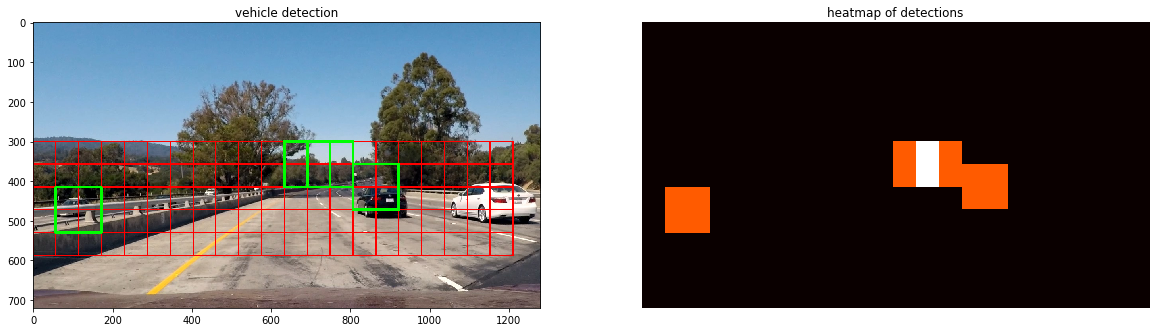

0.13 seconds processing time for image: ./test_images/test2.jpg


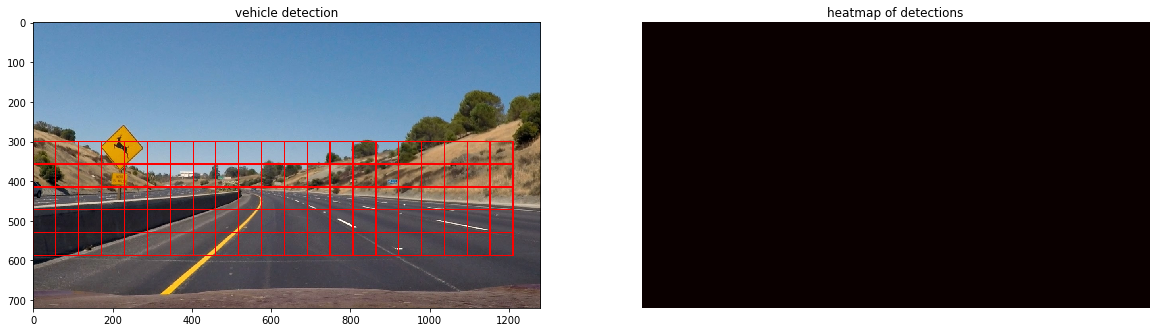

0.13 seconds processing time for image: ./test_images/test3.jpg


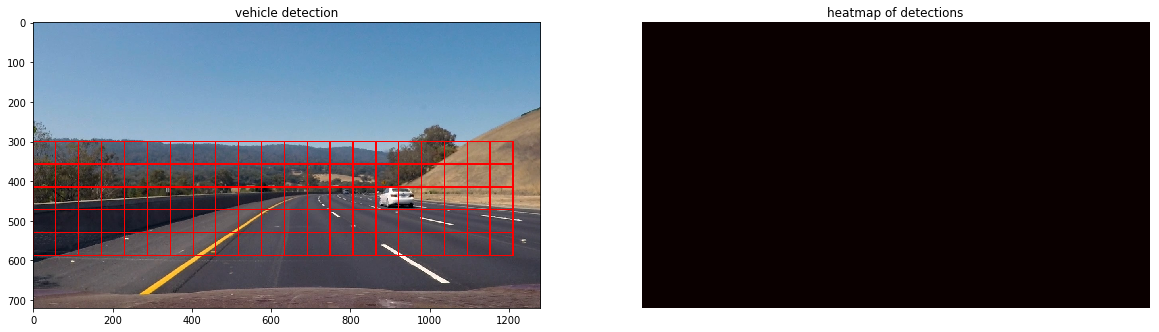

0.14 seconds processing time for image: ./test_images/test4.jpg


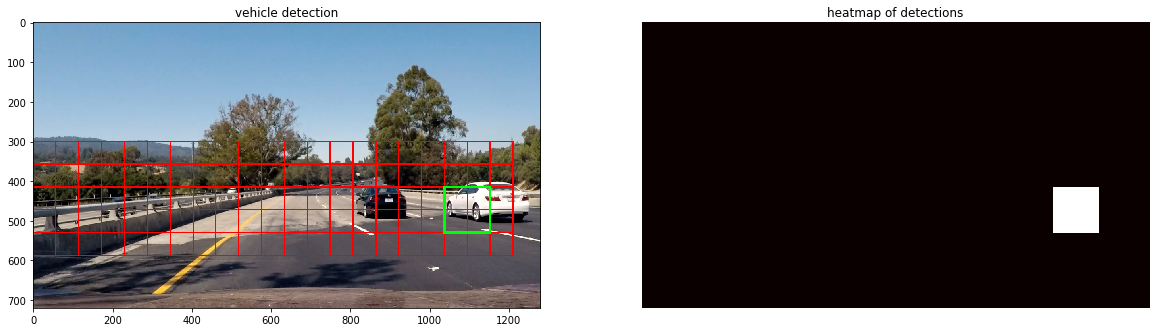

0.13 seconds processing time for image: ./test_images/test5.jpg


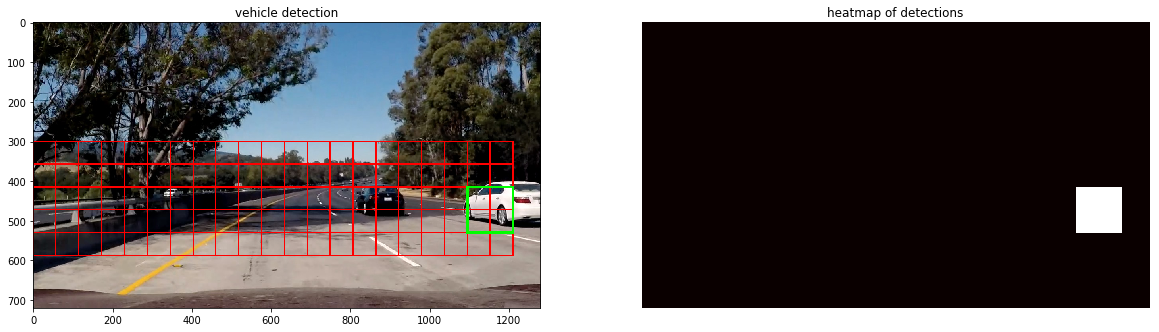

0.13 seconds processing time for image: ./test_images/test6.jpg


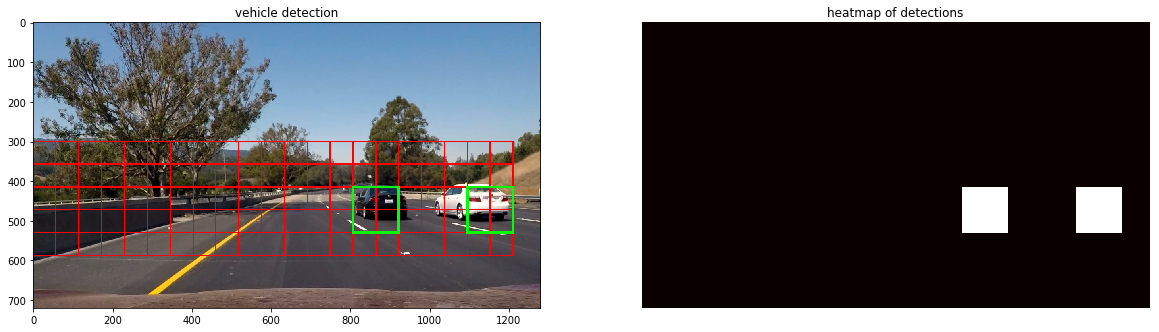

In [14]:
ystart = 300
ystop = 700 
scale = 1.0

test_img_paths = sorted(glob.glob(os.path.join(const['test_images'], '*.jpg')))
detections = {}
for img_path in test_img_paths:
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    t1=time.time()
    bboxes, out_img = find_cars(img, ystart, ystop, scale, model, scaler, 
                                feature_extraction_hyperparams['color_space'], 
                                feature_extraction_hyperparams['orient'], 
                                feature_extraction_hyperparams['pix_per_cell'], 
                                feature_extraction_hyperparams['cell_per_block'], 
                                feature_extraction_hyperparams['spatial_size'], 
                                feature_extraction_hyperparams['hist_bins'], 
                                spatial_feat=feature_extraction_hyperparams['spatial_feat'],
                                hist_feat=feature_extraction_hyperparams['hist_feat'], plot=True)
    t2 = time.time()
    print('{} seconds processing time for image: {}'.format(round(t2-t1, 2), img_path))
    detections[img_path] = bboxes
    heatmap = get_heatmap(img, bboxes)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(out_img)
    ax[0].set_title('vehicle detection')
    ax[1].imshow(heatmap, cmap='hot')
    ax[1].set_title('heatmap of detections')
    ax[1].axis('off')
    plt.show()

In [18]:
# Class for handle prediction and prediction time optimizations
class Detector():
    def __init__(self):
        self.MAX_WINDOW_SIZE = 25
        self.HEATMAP_THRESHOLD = 25.0
        self.heatmaps = np.zeros((self.MAX_WINDOW_SIZE, 720, 1280), dtype=np.float)
        self.last_heatmap_idx = 0
        self.REGIONS = [{'ystart': 380, 'ystop': 530, 'scale': 1.0}, 
                        {'ystart': 380, 'ystop': 620, 'scale': 1.5},
                        {'ystart': 380, 'ystop': 660, 'scale': 1.8}]
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 5)
        return img
    
    def add_heat(self, heatmap, bbox_list):
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        return heatmap

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        return heatmap


    def filter_false_positives(self, img, bboxes):    
        heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)

        # Add heat to each box in box list
        heatmap = self.add_heat(heatmap, bboxes)
        
        # Sum last N heatmaps where N = self.MAX_WINDOW_SIZE
        self.heatmaps[self.last_heatmap_idx] = heatmap
        self.last_heatmap_idx = (self.last_heatmap_idx + 1) % self.MAX_WINDOW_SIZE
        sum_heatmap = np.sum(self.heatmaps, axis=0)

        # Apply threshold to help remove false positives
        sum_heatmap = self.apply_threshold(sum_heatmap, self.HEATMAP_THRESHOLD)
        
        # Visualize the heatmap when displaying    
        sum_heatmap = np.clip(sum_heatmap, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(sum_heatmap)
        
        # Draw boxes
        draw_img = self.draw_labeled_bboxes(np.copy(img), labels)
    
        return draw_img

    def detect(self, img):
        bboxes = []
        for region in self.REGIONS:
            ystart = region['ystart']
            ystop = region['ystop']
            scale = region['scale']
            boxes = find_cars(img, ystart, ystop, scale, model, scaler, 
                                feature_extraction_hyperparams['color_space'], 
                                feature_extraction_hyperparams['orient'], 
                                feature_extraction_hyperparams['pix_per_cell'], 
                                feature_extraction_hyperparams['cell_per_block'], 
                                feature_extraction_hyperparams['spatial_size'], 
                                feature_extraction_hyperparams['hist_bins'], 
                                plot=False)
            
            bboxes.extend(boxes)
        result_img = self.filter_false_positives(img, bboxes)
        return result_img

In [13]:
# Creating the final output video
vehicleDetector = Detector()
ts = int(time.time())
output = 'output_project_video_{}.mp4'.format(str(ts))
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(vehicleDetector.detect)
%time clip.write_videofile(os.path.join(const['output_videos'], output), audio=False)
print('video saved to:', os.path.join(const['output_videos'], output))

[MoviePy] >>>> Building video ./output_videos/output_project_video_1514664384.mp4
[MoviePy] Writing video ./output_videos/output_project_video_1514664384.mp4


100%|█████████▉| 1260/1261 [08:24<00:00,  2.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_project_video_1514664384.mp4 

CPU times: user 8min 27s, sys: 1.92 s, total: 8min 29s
Wall time: 8min 26s
video saved to: ./output_videos/output_project_video_1514664384.mp4
